In [ ]:
# Import the necessary packages 
import os
import numpy as np
import pandas as pd
import random
import cv2
import seaborn as sns
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import argparse
import imutils
%matplotlib inline


from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset directory in Drive
train_data_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/Train'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/Test'

In [ ]:
# Data generation objects
train_datagen = ImageDataGenerator(zoom_range=0.1,     
                                   horizontal_flip = True,
                                   fill_mode = 'constant',
                                   validation_split=0.1,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
image_size = 224
batch_size = 32

# This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_datagen.flow_from_directory(train_data_path, 
                                              target_size=(image_size, image_size), 
                                              batch_size=batch_size, 
                                              class_mode='binary', 
                                              shuffle=True,
                                              subset='training')

val_gen = train_datagen.flow_from_directory(train_data_path, # same directory as training data
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle = True,
                                                  class_mode='binary',
                                                  subset='validation')

test_gen = test_datagen.flow_from_directory(test_data_path, 
                                                target_size=(image_size, image_size), 
                                                batch_size=batch_size, 
                                                class_mode='binary', 
                                                shuffle=True)

Found 2563 images belonging to 2 classes.
Found 284 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

#Dropout Layer
x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

#Check the model summary and trainable parameters
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [ ]:
#Follow ChexNeXt Paper
base_learning_rate = 0.0001

#Compile model
model.compile(loss='binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])


#epochs
initial_epochs = 10

# Callbacks
#Save best model
ckpt_filename= "/content/drive/My Drive/chest_xray/dn121_class_weights_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)





In [ ]:


history= model.fit(train_gen,
                   steps_per_epoch= len(train_gen),
                   epochs= epoch,
                   validation_data =val_gen
                   
                   )

Epoch 1/10
81/81 [==============================] - 1768s 22s/step - loss: 1.4664 - accuracy: 0.5622 - val_loss: 0.5753 - val_accuracy: 0.7324
Epoch 2/10
81/81 [==============================] - 500s 6s/step - loss: 0.8621 - accuracy: 0.6801 - val_loss: 0.3776 - val_accuracy: 0.8556
Epoch 3/10
81/81 [==============================] - 496s 6s/step - loss: 0.6952 - accuracy: 0.7261 - val_loss: 0.3366 - val_accuracy: 0.8803
Epoch 4/10
81/81 [==============================] - 524s 6s/step - loss: 0.5794 - accuracy: 0.7698 - val_loss: 0.4162 - val_accuracy: 0.8239
Epoch 5/10
81/81 [==============================] - 522s 6s/step - loss: 0.4922 - accuracy: 0.7998 - val_loss: 0.2884 - val_accuracy: 0.8944
Epoch 6/10
81/81 [==============================] - 516s 6s/step - loss: 0.4317 - accuracy: 0.8299 - val_loss: 0.2811 - val_accuracy: 0.9085
Epoch 7/10
81/81 [==============================] - 539s 7s/step - loss: 0.4293 - accuracy: 0.8295 - val_loss: 0.2731 - val_accuracy: 0.8838
Epoch 8/10


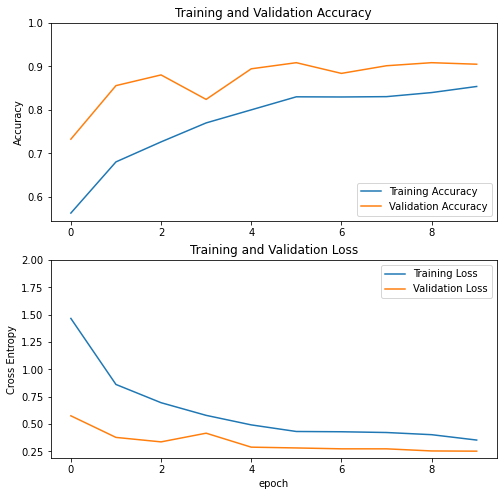

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [ ]:
base_model.trainable = True

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [ ]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_gen)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

20/20 [==============================] - 289s 15s/step - loss: 0.3847 - accuracy: 0.8446
Loss on test set:  0.38467657566070557
Accuracy on test set:  0.8445512652397156


In [ ]:
def fn_preprocess_images(data_directory, image_size):
  bacteria_pneumonia_dir = os.path.join(data_directory, 'Bacteria') 
  virus_pneumonia_dir = os.path.join(data_directory, 'Virus') 

  # Get the list of all the images
  bacteria_cases = glob(bacteria_pneumonia_dir + '/*.jpeg') 
  virus_cases = glob(virus_pneumonia_dir + '/*.jpeg')

  #Store all images and labels
  image_data_list = []
  labels = []
  
  for img_path in bacteria_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(0)

  for img_path in virus_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(1)
 
  #Convert the images to tensor shape (n_images, h, w, channel)
  img_data = np.array(image_data_list)
  img_data=np.rollaxis(img_data,1,0)
  img_data=img_data[0]
  print("Final data shape: "+str(img_data.shape))

  #convert label list to numpy array
  labels = np.array(labels)

  return img_data,labels